# Lab 1 &ndash; Running Grover on Qiskit

Please indicate here the names of the coworkers on this notebook:

- <span style="color: blue">Fridel WANKPO</span>
- <span style="color: blue">Cheikh BAMBA</span>
- <span style="color: blue">Romain DUJARDIN</span>

## A) Introduction to Qiskit

So far we used IBM Q's Composer interface to construct, execute and simulate quantum circuits, but the [Qiskit](https://www.ibm.com/quantum/qiskit) library provides a much more versatile and powerful way to manipulate these from a Jupyter notebook such as this one. You can run it locally on your computer by making sure you have the `qiskit`, `qiskit-aer` and `qiskit-ibm-runtime` libraries installed or in an online environement such as Google Colab (more details [here](https://docs.quantum.ibm.com/guides/install-qiskit)).

So make sure you have the Qiskit library for Python installed, then start by importing the features we will be using today:

In [4]:
# In your Python (<=3.13 at time of writing) environment:
!pip3 install qiskit qiskit-aer qiskit-ibm-runtime matplotlib

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_state_city, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.3 MB/s eta 0:00:00


Let us start by recreating one of our simplest circuits:

In [5]:
circ = QuantumCircuit(2)  # create a circuit with 2 qubits, q_0 and q_1
circ.h(0)                 # apply an H-gate on q_0
circ.cx(0,1)              # apply an X-gate on q_1 controlled by q_0
circ.draw()               # render the circuit visually

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Take a moment to make sure you make sense of what each of the lines above achieves (and of course feel free to experiment!). For more information, you can consult the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) for available gates.

The final quantum state of the circuit can be obtained by sending it to the `statevector_simulator`:

In [6]:
state_simulator = Aer.get_backend('statevector_simulator')

job = state_simulator.run(circ)
answer = job.result().get_statevector()
answer

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Here you can see that the quantum state of the 2-qubit system (initialized at $|00\rangle$) is &ndash; as it should! &ndash; the Bell state

$$ |\psi\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}. $$

Another way to visualize the output is to look instead at the _density matrix_ $\rho = |\psi\rangle \langle\psi|$ of the output state (the probabilities of measuring each basis state can be read from the diagonal of the matrix):
$$ \rho = \begin{bmatrix} \frac{1}{2} & 0 & 0 & \frac{1}{2} \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ \frac{1}{2} & 0 & 0 & \frac{1}{2} \end{bmatrix}. $$

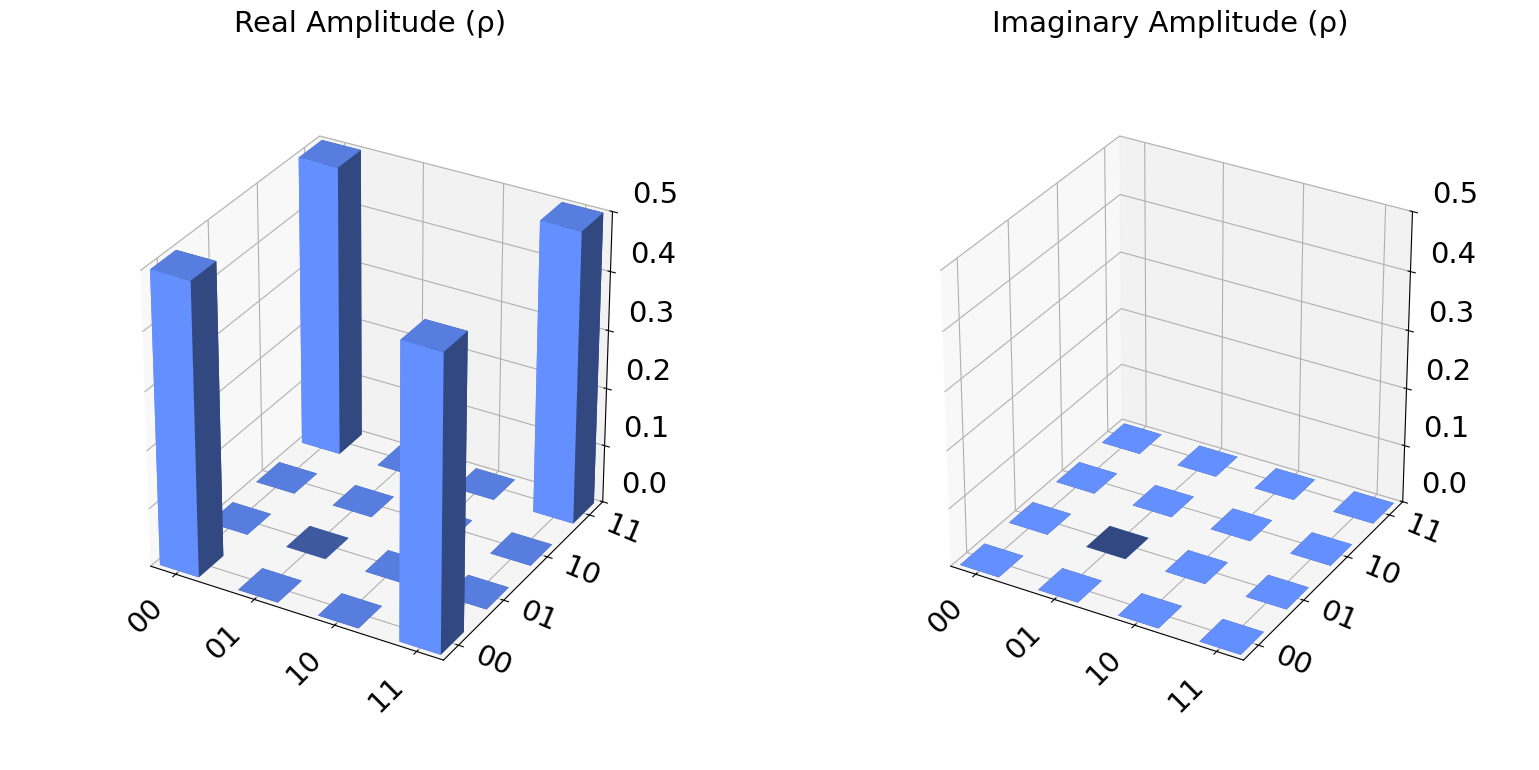

In [7]:
plot_state_city(answer)

If one wants to prepare the qubits in other initial states, it could be useful to turn out circuit into a function that can be used to easily append the required gates to a given circuit.

In [8]:
def bell(qc):
    qc.h(0)
    qc.cx(0,1)

In [9]:
init_circ = QuantumCircuit(2)
init_circ.x(0)
init_circ.barrier()
bell(init_circ)
init_circ.draw()

┌───┐ ░ ┌───┐     
q_0: ┤ X ├─░─┤ H ├──■──
     └───┘ ░ └───┘┌─┴─┐
q_1: ──────░──────┤ X ├
           ░      └───┘

This initializes the qubits in the $|01\rangle$ state (remember that here $q_0$ comes _last_) and runs them through our circuit. You could then recover the output state by the above procedure as we did in class.

Note: you can also easily recover the global unitary matrix corresponding to the quantum circuit by sending it to the `unitary_simulator`.

In [10]:
unit_simulator = Aer.get_backend('unitary_simulator')

job = unit_simulator.run(circ)

job.result().get_unitary()

Operator([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j],
          [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
          [ 0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j]],
         input_dims=(2, 2), output_dims=(2, 2))


 **To do**: construct the following circuit
 ![image.png](attachment:image.png)

 where $T = P(\frac{\pi}{4}) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i \frac{\pi}{4}} \end{bmatrix}$ (directly available as a `t` gate, whereas its inverse $T^\dagger = P(-\frac{\pi}{4})$ is `tdg`).

 Write down its $8 \times 8$ unitary matrix representation. Do you recognize this $3$-qubit gate? Try to confirm your answer.

In [96]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

# 1. Construction du circuit
# Nous avons 3 qubits. Les lignes de l'image correspondent aux indices :
# Ligne du haut : q0
# Ligne du milieu : q1
# Ligne du bas : q2
qc = QuantumCircuit(3)

# Lecture du circuit de gauche à droite
qc.h(2)             # H sur q2
qc.cx(1, 2)         # CNOT (q1 contrôle, q2 cible)
qc.tdg(2)           # T dagger sur q2
qc.cx(0, 2)         # CNOT (q0 contrôle, q2 cible)
qc.t(2)             # T sur q2
qc.cx(1, 2)         # CNOT (q1 contrôle, q2 cible)
qc.tdg(2)           # T dagger sur q2
qc.cx(0, 2)         # CNOT (q0 contrôle, q2 cible)


# Bloc de droite
qc.t(2)             # T sur q2
# qc.t(1)             # T sur q1
qc.h(2)             # H sur q2 (fin de la ligne du bas)

qc.barrier()
qc.t(1)             # T sur q1 (présent sur la ligne du haut du schéma)

qc.cx(0, 1)         # CNOT (q0 contrôle, q1 cible)
qc.t(0)             # T sur q0
qc.tdg(1)           # T dagger sur q1
qc.cx(0, 1)         # CNOT (q0 contrôle, q1 cible)

# Afficher le circuit pour vérifier qu'il correspond à l'image
print("Schéma du circuit construit :")
print(qc)

# 2. Calcul de la représentation matricielle unitaire 8x8
U = Operator(qc)
unitary_matrix = U.data

# Affichage propre de la matrice (arrondi pour la lisibilité)
print("\nMatrice Unitaire (arrondie à 3 décimales) :")
print(np.round(unitary_matrix, 3))

Schéma du circuit construit :
                                                            ░            ┌───┐ »
q_0: ───────────────────■─────────────────────■─────────────░────────■───┤ T ├─»
                        │                     │             ░ ┌───┐┌─┴─┐┌┴───┴┐»
q_1: ───────■───────────┼─────────■───────────┼─────────────░─┤ T ├┤ X ├┤ Tdg ├»
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌───┐ ░ └───┘└───┘└─────┘»
q_2: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ H ├─░──────────────────»
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘└───┘ ░                  »
«          
«q_0: ──■──
«     ┌─┴─┐
«q_1: ┤ X ├
«     └───┘
«q_2: ─────
«          

Matrice Unitaire (arrondie à 3 décimales) :
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0

La matrice unitaire du circuit construit correspond à une porte Toffoli à trois qubits (CCX).

En effet, la matrice laisse tous les états de base de calcul inchangés, à l'exception de ∣110⟩ et ∣111⟩, qui sont permutés.

Ce comportement est caractéristique d'une porte CCX (contrôlée-contrôlée-X) avec des commandes sur les qubits q0 et q1 et cible q2.

De plus, l'équivalence est confirmée par la comparaison de la matrice unitaire du circuit avec celle d'une porte CCX fournie par Qiskit, à une phase globale près, ce qui donne une correspondance exacte.

In [64]:
from qiskit.circuit.library import CCXGate

qc_ref = QuantumCircuit(3)
qc_ref.append(CCXGate(), [0, 1, 2])

U1 = Operator(qc).data
U2 = Operator(qc_ref).data

phase = U1[0,0] / U2[0,0]
print(np.allclose(U1, phase * U2))


True


## B) Grover with $N = 4$

Let us implement Grover's search algorithm in a space of size $N = 4$ (hence written on $n = 2$ qubits). Suppose to fix ideas we want to find the element $\omega = 10$ in the set $X = \{00, 01, 10, 11\}$.

![image.png](attachment:image.png)

In this situation, we are able to construct directly the phase-flip oracle $U_w$ without the need of an ancillary qubit, so let us just get rid of it. The first thing we need to do is intialize our first 2 qubits to the equal superposition state

$$ |s\rangle = \frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{2}. $$

In [70]:
def full_h(qc):
    for i in range(qc.num_qubits):
        qc.h(i)

In [71]:
circ = QuantumCircuit(2)
full_h(circ)
circ.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

For $n = 2$, the equal superposition state $|s\rangle$ makes an initial angle $\frac{\theta}{2} = \arcsin \frac{1}{\sqrt{4}} = \arcsin \frac{1}{2} = \frac{\pi}{6}$ with the horizontal $|s'\rangle$ in the plan spanned by $|s\rangle$ and $|\omega\rangle$. After one rotation of $\theta = \frac{\pi}{3}$, an angle of $\frac{\pi}{2}$ is reached so the state will be exactly $|\omega\rangle$ after a single iteration of the phase amplification stage.

So we only need to apply the $U_\omega$ phase flip oracle, to invert the phase of $|10\rangle$ and leave the 3 other basis vectors untouched. You may check that this can be achieved using a combination of $X$ and controlled-$Z$ gates:

In [72]:
def oracle(qc):
    qc.x(0)
    qc.cz(0,1)
    qc.x(0)

In [73]:
circ.barrier()
oracle(circ)
circ.draw()

┌───┐ ░ ┌───┐   ┌───┐
q_0: ┤ H ├─░─┤ X ├─■─┤ X ├
     ├───┤ ░ └───┘ │ └───┘
q_1: ┤ H ├─░───────■──────
     └───┘ ░

We then need to apply the $U_s = H^{\otimes 2} \, U_0 \, H^{\otimes 2}$ reflection operator (the global sign can be safely discarded). Again $U_0$ can be achieved using a combination of $X$ and $CZ$ gates.

In [74]:
def full_x(qc):
    for i in range(qc.num_qubits):
        qc.x(i)

def g(qc):
    # Hadamard gates
    full_h(qc)
    # U_0
    full_x(qc)
    qc.cz(0,1)
    full_x(qc)
    # Hadamard gates
    full_h(qc)

In [75]:
circ.barrier()
g(circ)
circ.draw()

┌───┐ ░ ┌───┐   ┌───┐ ░ ┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘ ░               ░ └───┘└───┘   └───┘└───┘

We can confirm that the output state should be $|10\rangle$ with probability 1:

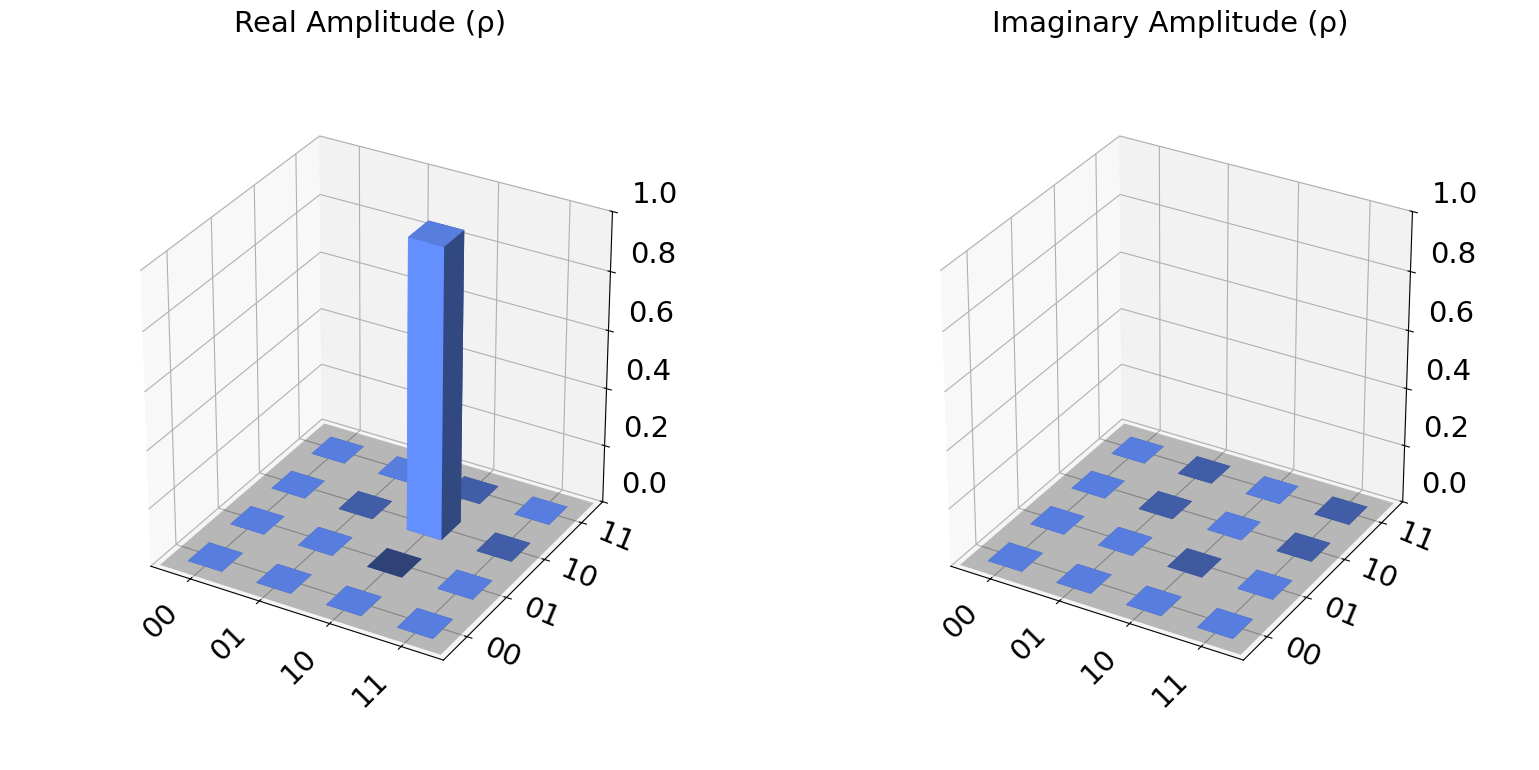

In [76]:
state_simulator = Aer.get_backend('statevector_simulator')

job = state_simulator.run(circ)
answer = job.result().get_statevector()

plot_state_city(answer)

Let us now add measurements and _simulate_ the execution of the algorithm:

In [77]:
circ.measure_all()
circ.draw()

┌───┐ ░ ┌───┐   ┌───┐ ░ ┌───┐┌───┐   ┌───┐┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─┤M├───
        ├───┤ ░ └───┘ │ └───┘ ░ ├───┤├───┤ │ ├───┤├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░──╫─┤M├
        └───┘ ░               ░ └───┘└───┘   └───┘└───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════╩══╩═
                                                           0  1

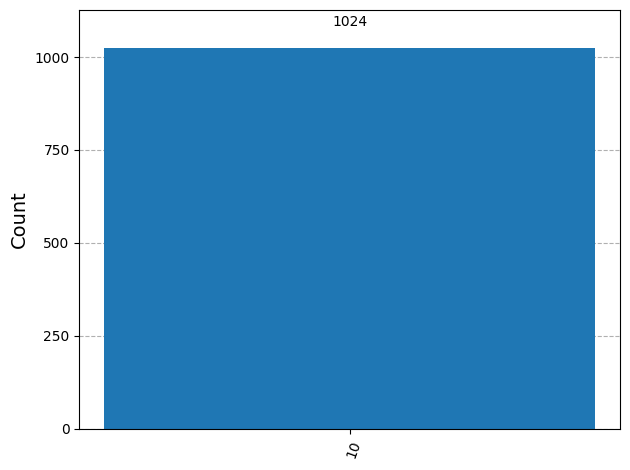

In [78]:
qasm_simulator = Aer.get_backend('qasm_simulator')

job = qasm_simulator.run(circ, shots=1024)

results = job.result()
answer = results.get_counts()
plot_histogram(answer)

We can also send our circuit to an actual quantum computer, using the API token from your IBM Quantum account (job will be run asynchronously but it may take some time):

In [90]:
api_key = "NtxiaNG3LafPvaZzVupckskWn0ZQS-7Bjf8LgTTtXZdW"# your own API key here

In [91]:
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=api_key)

backend = service.least_busy(operational=True, simulator=False)

print("Jobs will be running on %s" % backend.name)

qiskit_runtime_service._discover_account:WARNING:2026-01-28 15:27:59,538: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-01-28 15:28:02,123: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-28 15:28:02,473: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-28 15:28:03,630: Using instance: open-instance, plan: open


Jobs will be running on ibm_torino


In [92]:
# non-blocking, you may continue to evalue other cells

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
new_circuit = pm.run(circ)

sampler = Sampler(mode=backend)

job = sampler.run([new_circuit])

In [94]:
# check if job is done
print("Job ID: %s" % job.job_id())
print("Status: %s" % job.status())

Job ID: d5t2m2ghusoc73eqfrq0
Status: DONE


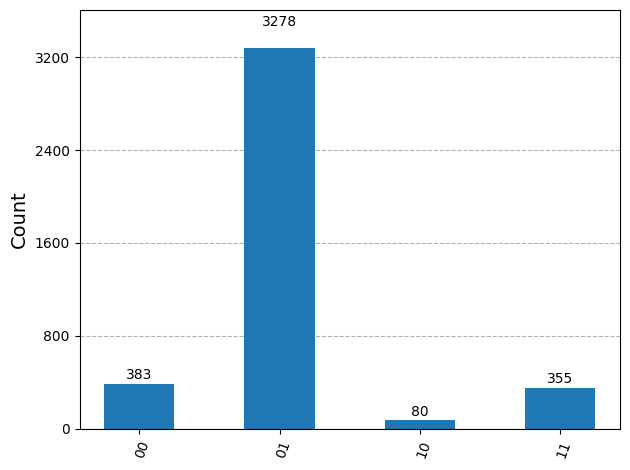

In [95]:
# waiting for the job to finish, however, *is* blocking, do not run until job is done
results = job.result()[0]
answer = results.data.meas.get_counts()
plot_histogram(answer)

Some (gate + measurement) errors are to be expected!

**To do**: Go through the same process again, this time looking for another element $\omega \in X$ of your choice.

ω=∣01⟩

Circuit de recherche pour l'élément |01> :
        ┌───┐ ░               ░ ┌───┐┌───┐   ┌───┐┌───┐ ░  ░ ┌─┐   
   q_0: ┤ H ├─░───────■───────░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░──░─┤M├───
        ├───┤ ░ ┌───┐ │ ┌───┐ ░ ├───┤├───┤ │ ├───┤├───┤ ░  ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ X ├─■─┤ X ├─░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░──░──╫─┤M├
        └───┘ ░ └───┘   └───┘ ░ └───┘└───┘   └───┘└───┘ ░  ░  ║ └╥┘
meas: 2/══════════════════════════════════════════════════════╩══╩═
                                                              0  1 

Résultats de la mesure : {'01': 1024}


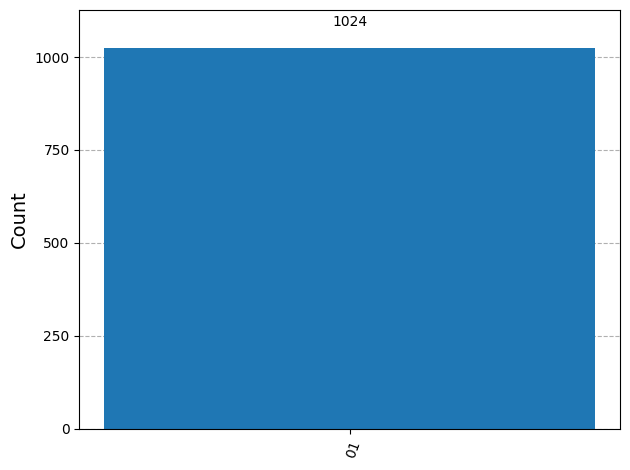

In [87]:
# 1. Choix de la nouvelle cible : omega = |01> (q1=0, q0=1)
def oracle_01(qc):
    # On inverse q1 pour que l'état |01> devienne |11> temporairement
    qc.x(1)
    # Le CZ agit sur |11>
    qc.cz(0, 1)
    # On rétablit q1
    qc.x(1)

# 2. Construction du circuit complet
qc_search = QuantumCircuit(2)

# A. Initialisation (Superposition uniforme)
full_h(qc_search)
qc_search.barrier()

# B. Application de l'Oracle spécifique
oracle_01(qc_search)
qc_search.barrier()

# C. Diffuseur de Grover (Fonction g définie précédemment dans le TP)
g(qc_search)
qc_search.barrier()

# D. Mesure
qc_search.measure_all()

# Affichage du circuit
print("Circuit de recherche pour l'élément |01> :")
print(qc_search.draw())

# 3. Simulation
# Récupération du simulateur (déjà importé plus haut dans le TP)
qasm_sim = Aer.get_backend('qasm_simulator')

# Exécution
job = qasm_sim.run(qc_search, shots=1024)
result = job.result()
counts = result.get_counts()

# Affichage des résultats
print("\nRésultats de la mesure :", counts)
plot_histogram(counts)

## C) Grover with $N = 8$

**Todo**: a) Implement a Grover search on $n=3$ qubits for the state $\omega = 111$. Here the phase-flip $U_\omega$ oracle can be implemented as a controlled-controlled-$Z$ gate, constructed from a $CCX$ (Toffoli) gate and the fact that $Z = HXH$:

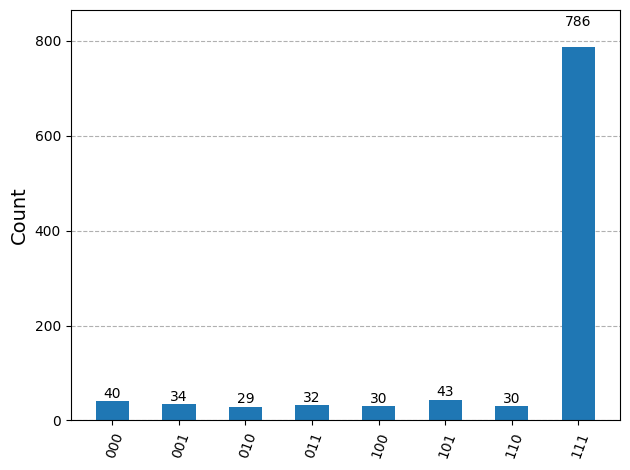

In [105]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Oracle CCZ = H • CCX • H
def oracle_111(qc):
    qc.h(2)
    qc.ccx(0, 1, 2)   # Toffoli
    qc.h(2)


def diffuser(qc):
    qc.h(range(3))
    qc.x(range(3))
    qc.h(2)
    qc.ccx(0, 1, 2)
    qc.h(2)
    qc.x(range(3))
    qc.h(range(3))


qc = QuantumCircuit(3)

# Superposition uniforme
qc.h(range(3))
qc.barrier()

# Grover (k = 1)
oracle_111(qc)
qc.barrier()
diffuser(qc)
qc.barrier()

# Mesure
qc.measure_all()

# Simulation
backend = Aer.get_backend("qasm_simulator")
job = backend.run(qc, shots=1024)
counts = job.result().get_counts()

plot_histogram(counts)



You may experiment with different numbers $k$ of iterations of the amplitude amplification step $(G U_\omega)^k $ and compare with the optimal value predicted by theory.

In [106]:
import math

def grover_circuit(k):
    qc = QuantumCircuit(3)
    qc.h(range(3))

    for _ in range(k):
        oracle_111(qc)
        diffuser(qc)

    qc.measure_all()
    return qc

backend = Aer.get_backend("qasm_simulator")

for k in range(5):
    qc_k = grover_circuit(k)
    job = backend.run(qc_k, shots=1024)
    counts = job.result().get_counts()

    print(f"k = {k}, probabilité de |111> =", counts.get("111", 0) / 1024)


k = 0, probabilité de |111> = 0.1259765625
k = 1, probabilité de |111> = 0.8037109375
k = 2, probabilité de |111> = 0.9521484375
k = 3, probabilité de |111> = 0.3212890625
k = 4, probabilité de |111> = 0.0107421875


Pour N = 8 et une seule solution, la théorie prédit un nombre optimal d’itérations k≈π/4*sqrt(8)≈2

Les simulations confirment que la probabilité de mesurer ∣111⟩ est maximale pour k = 2.
Au-delà, l’algorithme dépasse l’optimum et la probabilité redescend.



b) Same question, but this time using the following phase-flip oracle: ![image.png](attachment:image.png) What is the optimal number of iterations this time? Can you explain what is happening?

In [115]:
# Oracle alternatif (celui de l'image)
def oracle_image(qc):
    qc.x(1)
    qc.x(2)
    qc.h(2)
    qc.ccx(0, 1, 2)   # ← correction ici
    qc.h(2)
    qc.x(1)
    qc.x(2)


def grover_image(k):
    qc = QuantumCircuit(3)

    # Superposition uniforme
    qc.h(range(3))

    for _ in range(k):
        oracle_image(qc)
        diffuser(qc)

    qc.measure_all()
    return qc


backend = Aer.get_backend("qasm_simulator")

for k in range(5):
    qc_k = grover_image(k)
    job = backend.run(qc_k, shots=1024)
    counts = job.result().get_counts()
    print(f"k = {k}, distribution =", counts)


k = 0, distribution = {'001': 131, '111': 147, '011': 110, '100': 132, '110': 126, '000': 129, '010': 130, '101': 119}
k = 1, distribution = {'110': 26, '100': 31, '111': 32, '011': 40, '000': 37, '010': 33, '101': 29, '001': 796}
k = 2, distribution = {'101': 7, '110': 6, '111': 5, '011': 6, '100': 8, '010': 6, '000': 14, '001': 972}
k = 3, distribution = {'010': 82, '000': 96, '111': 99, '011': 107, '110': 131, '101': 100, '001': 325, '100': 84}
k = 4, distribution = {'001': 8, '100': 141, '000': 144, '010': 146, '101': 152, '111': 160, '011': 135, '110': 138}


In [116]:
from qiskit.visualization import circuit_drawer

qc_test = QuantumCircuit(3)
oracle_image(qc_test)
qc_test.draw("text")

q_0: ────────────■────────────
     ┌───┐       │  ┌───┐     
q_1: ┤ X ├───────■──┤ X ├─────
     ├───┤┌───┐┌─┴─┐├───┤┌───┐
q_2: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

Dans ce cas, l’oracle ne marque pas l’état ∣111⟩ mais l’état ∣001⟩.
Les résultats montrent une amplification maximale de ∣001⟩ pour k = 2, ce qui correspond au nombre optimal d’itérations prédit par la théorie pour une seule solution dans un espace de taille N = 8.
Lorsque k dépasse cette valeur, l’algorithme dépasse le maximum d’amplification et la distribution redevient quasi uniforme.